In [ ]:
%reset -f
%matplotlib widget

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
plt.close('all')

import numpy as np
from scipy.optimize import fsolve

import sys
sys.path.append('../')

import pcmls

import jax
jax.config.update('jax_enable_x64', True)
jax.config.update('jax_debug_nans', True)

import jax.numpy as jnp
from jax import grad, hessian, jit, vmap

import progressbar

## Define Heteroclinic Flip Potential and Analyze Fixed Points

In [ ]:
# Set the heteroclinic flip parameters
p3 = -0.75
p4 = 0.4

def heteroclinic_flip(x):
    flip_pot = (x[0]**4 + x[1]**4 + x[0]**3 - 2 * x[0] * x[1]**2
                - x[0]**2 + p3 * x[0] + p4 * x[1])
    return flip_pot

vflip = jit(vmap(heteroclinic_flip, in_axes=0))

grad_flip = grad(heteroclinic_flip, argnums=0)
vgrad_flip = jit(vmap(grad_flip, in_axes=0))

hess_flip= hessian(heteroclinic_flip, argnums=0)
vhess_flip = jit(vmap(hess_flip, in_axes=0))

In [ ]:
# Find the fixed points of the flow
x, y = np.meshgrid(np.linspace(-2, 2, 5), np.linspace(-2, 2, 5))
initial_points = jnp.array(np.column_stack((x.ravel(), y.ravel())))

fixed_points = []
for point in progressbar.progressbar(initial_points):
    if jnp.array_equal(point, jnp.zeros_like(point, shape=(2,))): continue
    fixed_points.append(fsolve(grad_flip, point))
    
fixed_points = np.array(fixed_points)
_, unique_indices = np.unique(np.round(fixed_points, 5),
                              return_index=True, axis=0)
fixed_points = fixed_points[unique_indices]

# Double check that the fixed points actually have a vanishing gradient
# (For some reason using 'fsolve' seems to think that [0.0, 0.0] is a
# fixed point)
fixed_points = [point for point in fixed_points if \
                (np.linalg.norm(grad_flip(point)) < 1e-4)]
fixed_points = jnp.array(fixed_points)

## Assess the stability of the fixed points
true_flow_jac = -vhess_flip(fixed_points)
fixed_point_lambda = []
for jac in true_flow_jac:
    fixed_point_lambda.append(np.max(np.real(np.linalg.eigvals(jac))))
fixed_point_lambda = np.array(fixed_point_lambda)

del x, y, point, initial_points, unique_indices, jac

#### View Results

In [ ]:
# A uniform grid defined over [-2 2] X [0 1]
px, py = np.meshgrid(np.linspace(-2, 2, 50), np.linspace(-2, 2, 50))
u = vflip(np.column_stack((px.ravel(), py.ravel())))
u = u.reshape(px.shape)

plt.close('all')
fig = plt.figure()
ax = fig.add_subplot(111)

cont = ax.contourf(px, py, u, np.linspace(np.min(u), 2, 10),
                   cmap='viridis', extend='max')
sc1 = ax.scatter(fixed_points[fixed_point_lambda < 0, 0],
                fixed_points[fixed_point_lambda < 0, 1], c='m', s=20)
sc2 = ax.scatter(fixed_points[fixed_point_lambda > 0, 0],
                fixed_points[fixed_point_lambda > 0, 1], c='c', s=20)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Heteroclinic Flip Potential')
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

## Generate Points by Simulating Stochastic ODE

In [ ]:
D = 0.5  # The diffusion coefficient
dt = 0.01 # The time step

np.random.seed(42) # For reproducible random numbers

# Generate initial point set
num_points = 3000
p = np.tile(fixed_points[2,:], (num_points, 1))
p += np.random.randn(num_points, 2) * 0.1

# Choose simulation stopping times
max_time_point = int(5e3)
stop_times = np.random.choice(np.array(range(max_time_point)),
                              num_points, replace=False)

active_points = stop_times > 0
stop_times = stop_times[active_points]
active_points = np.where(active_points)[0]

t = 2
progress = progressbar.ProgressBar(max_value=num_points)
while (active_points.size > 0) and (t < max_time_point):
    num_active = active_points.size
    progress.update(num_points-num_active)
    
    # Update the active points
    cur_grad = vgrad_flip(p[active_points, :])
    p[active_points, :] -= (dt * cur_grad + np.sqrt(2 * dt * D) *
                            np.random.randn(num_active, 2))
    
    # Determine which points are still active
    cur_stop = stop_times == t
    active_points = active_points[~cur_stop]
    stop_times = stop_times[~cur_stop]
    t += 1
    
progress.finish()

del max_time_point, stop_times, active_points, t, progress
del num_active, cur_grad, cur_stop

In [55]:
# Compute the Jacobians of the flow using PCMLS
up = vflip(p)
_, _, test_flow_jac = pcmls.pcmls(fixed_points, p, up, m=4, weight_function='wendland',
                     weight_method='knn', weight_param=20, vectorized=True,
                     compute_gradients=False, compute_hessians=True,
                     verbose=True)
test_flow_jac = -test_flow_jac

if jnp.allclose(test_flow_jac, true_flow_jac):
    print('Flow Jacobians are close')
else:
    print('Flow Jacobians are NOT close')

Computing function values... Done
Computing Hessians... Done
Flow Jacobians are close


#### View Results

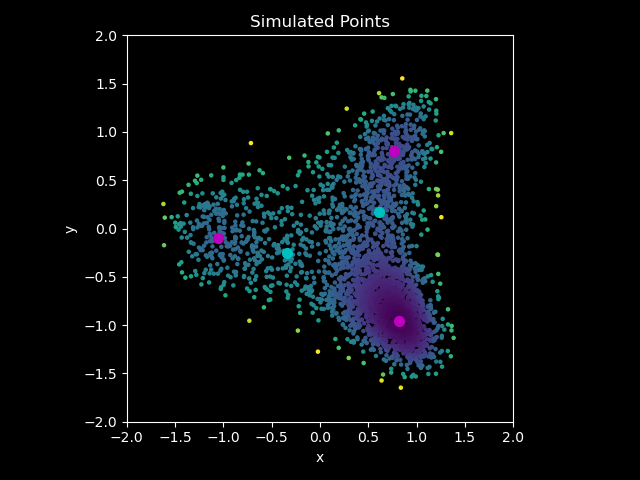

In [53]:
plt.close('all')
plt.style.use('dark_background')
fig = plt.figure()
ax = fig.add_subplot(111)

sc = ax.scatter(p[:,0], p[:,1], c=vflip(p), cmap='viridis', s=5)
sc1 = ax.scatter(fixed_points[fixed_point_lambda < 0, 0],
                fixed_points[fixed_point_lambda < 0, 1], c='m', s=50)
sc2 = ax.scatter(fixed_points[fixed_point_lambda > 0, 0],
                fixed_points[fixed_point_lambda > 0, 1], c='c', s=50)
ax.set_xlabel('x', color='white')
ax.set_ylabel('y', color='white')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
sc.set_clim(np.min(vflip(fixed_points)), 2)
ax.set_aspect('equal')
ax.set_title('Simulated Points', color='white')

plt.tight_layout()
plt.show()